In [1]:
import os
import sys
sys.path.append("./src")
from soil_models import *
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import get_tstamp
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

matplotlib.rcParams.update({'font.size': 16})


psd_data = '/fd1/QibinShi_data/England_farm/psd_all.hdf5'  ## big file on server
harper_met = 'data/NewportSalop_merged.csv'
reg_met = 'data/met_newport.csv'
spatial_data = 'data/interp_dv_tillage_tire.csv'

# Data

## Read soil physics

In [11]:
soil_phy = pd.read_csv('data/interpolated_soil_phy.csv')
interp_porosity_10cm = soil_phy['interp_porosity_10cm'].values
interp_porosity_20cm = soil_phy['interp_porosity_20cm'].values
interp_porosity_30cm = soil_phy['interp_porosity_30cm'].values
interp_bulk_density_10cm = soil_phy['interp_bulk_density_10cm'].values
interp_bulk_density_20cm = soil_phy['interp_bulk_density_20cm'].values
interp_bulk_density_30cm = soil_phy['interp_bulk_density_30cm'].values

## Read dV/V

In [12]:
# with h5py.File('data/final_peaks_interp_smooth.h5', 'r') as f:
#     dvv_all = f['smooth1d_dvv'][:]

# dvv = dvv_all[18]

with h5py.File('data/final_peaks_deRatio_2iterations.h5', 'r') as f:
    deratio_dvv = f['deratio_dvv'][:]

interp_f = interp1d(np.arange(0,2408,5), deratio_dvv, axis=-1, bounds_error=False, fill_value="extrapolate")
interp_dvv = interp_f(np.arange(2408))
dvv_all = gaussian_filter1d(interp_dvv, sigma=4, axis=-1)
# dvv_all = interp_dvv

## Read damage index

In [22]:
damage_index =pd.read_csv('data/damage_index.csv')
damage_index = damage_index['damage_index'].values
damage_index[18]

0.3973460025284925

## Read the PSD of DAS

In [13]:
### PSD of high frequency DAS
with h5py.File(psd_data, 'r') as f:
    freq = f['frequency'][:]
    file_list = f['daslist'][:]
    PSD_all_time = f['psd_all_time'][:]
    
acqu_time = np.array([get_tstamp(i) for i in file_list.astype('U')])


## Index on the hour
hourly_index = [67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]

## Mean PSD over channels
ave_psd=np.mean(np.sum(PSD_all_time[0:44, :, 52:90], axis=-1) * (freq[1]-freq[0]), axis=0) - 0.0007

Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]

xax=np.arange(7, ave_psd.shape[-1], 360)
tax=acqu_time[7:ave_psd.shape[-1]:360]
hrax=[dt.strftime('%H') for dt in tax]

## Read regional Met data

In [14]:
### regional weather data
csv_file = pd.read_csv(reg_met)
air_temp = csv_file['Temperature'].to_numpy()
wind_speed = csv_file['Wind Speed'].to_numpy()*1000/3600
humidity = csv_file['Humidity'].to_numpy()

air_temp_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(air_temp) * 30, 30), air_temp)
wind_speed_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(wind_speed) * 30, 30), wind_speed)
humidity_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(humidity) * 30, 30), humidity)


## Read the Met data at the farm

In [15]:
### Read the site weather data
csv_file = pd.read_csv(harper_met, low_memory=False).dropna(axis='columns', how='all')
j = 32   ## index of the beginning time
humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
grs_temp = csv_file['Grass Temperature'][j+1:j+40].to_numpy()
air_temp = csv_file['Dry Bulb Temperature'][j+1:j+40].to_numpy()
dew_temp = csv_file['Dew Point Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
rainfall = csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)
rain_diff[np.where(rain_diff<0)]=0

interpx = np.arange(ave_psd.shape[0])
interp_f = interp1d(hourly_index, humidity, bounds_error=False, fill_value="extrapolate")
interp_humidity = interp_f(interpx)
interp_f = interp1d(hourly_index, soil_temp_10, bounds_error=False, fill_value="extrapolate")
interp_temp10 = interp_f(interpx)

air_temp_add1 = np.insert(air_temp, 0, 12)
air_temp_local = np.interp(interpx, np.arange(0, len(air_temp_add1) * 60, 60), air_temp_add1)

### use dew point temperature to calculate the relative humidity
dew_temp_add1 = np.insert(dew_temp, 0, 9)
dew_temp_local = np.interp(np.arange(0, 2408), np.arange(0, len(dew_temp_add1) * 60, 60), dew_temp_add1)
r_humidity = 100 * np.exp((17.27 * dew_temp_local) / (dew_temp_local + 237.3)) / np.exp((17.27 * air_temp_local) / (air_temp_local + 237.3))

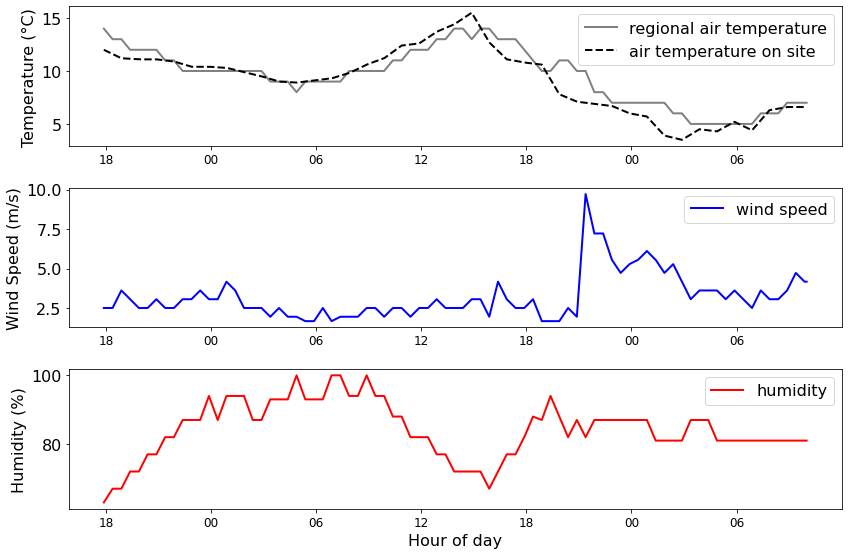

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True)

# Plot regional air temperature and air temperature on site
ax1.plot(np.arange(2408), air_temp_interpolated, label='regional air temperature', color='gray', lw=2)
ax1.plot(np.arange(2408), air_temp_local, label='air temperature on site', color='k', linestyle='--', lw=2)
ax1.set_ylabel("Temperature (°C)", fontsize=16)
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax, fontsize=12)
ax1.legend()

# Plot wind speed
ax2.plot(np.arange(2408), wind_speed_interpolated, label='wind speed', color='blue', lw=2)
ax2.set_ylabel("Wind Speed (m/s)", fontsize=16)
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=12)
ax2.legend()

# Plot humidity
ax3.plot(np.arange(2408), humidity_interpolated, label='humidity', color='r', lw=2)
ax3.set_xlabel("Hour of day", fontsize=16)
ax3.set_ylabel("Humidity (%)", fontsize=16)
ax3.set_xticks(xax)
ax3.set_xticklabels(hrax, fontsize=12)
ax3.legend()

plt.show()

## Compare PSD with rainfall

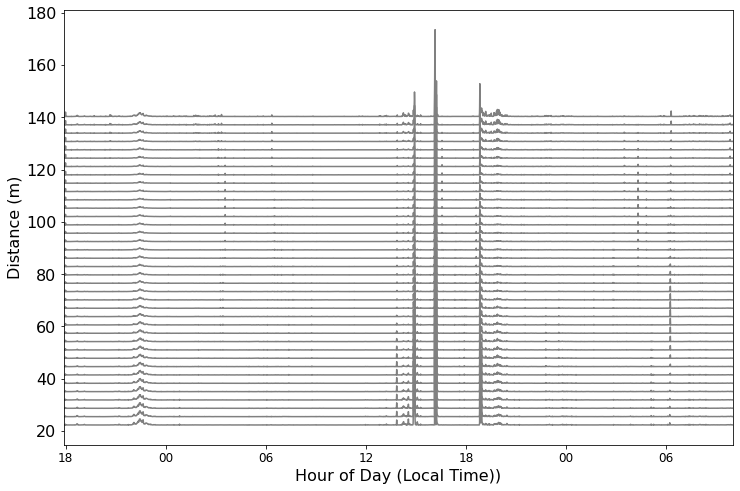

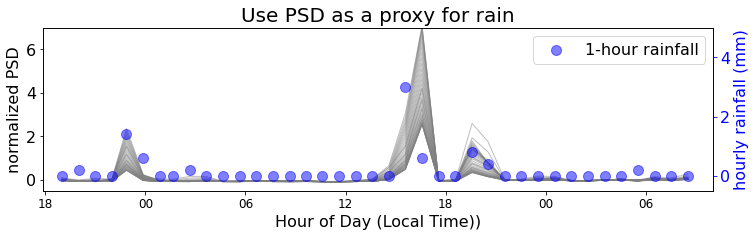

In [17]:
### Plot1
plt.figure(figsize=(12, 8))
plt.xlabel("Hour of Day (Local Time))", fontsize = 16)
plt.ylabel("Distance (m)", fontsize = 16)
# plt.yticks(np.arange(44,95,5), np.arange(44,95,5)*3.19, fontsize = 12)
plt.xlim(0, ave_psd.shape[-1])
int_PSD=np.sum(PSD_all_time[:, :, 52:90], axis=-1) * (freq[1]-freq[0])* 3
# int_PSD=int_PSD / np.std(int_PSD, axis=1, keepdims=True)/20
int_PSD=gaussian_filter1d(int_PSD, 4, axis=0) - 0.003

for ch in np.arange(7,45):
    plt.plot(np.arange(2408), int_PSD[ch, :]* 20 + ch *3.19, label='Ch{}'.format(ch), color='gray')
    plt.xticks(xax, hrax, fontsize = 12)

# plt.savefig('psd_1min.pdf')


### Plot2
plt.figure(figsize = (12, 3))   
# plt.scatter(hourly_index, np.array(hr_psd), label='1-hour PSD', color='b', marker='*', s=100)
for ch in np.arange(7,45):
    ## sum PSD over 1 hr window
    hr_psd=[]
    for ind in hourly_index:
        st_ind = int(ind - 60)
        ed_ind = st_ind + 60
        hr_psd.append(np.sum(int_PSD[ch, st_ind:ed_ind]))
    plt.plot(hourly_index, np.array(hr_psd), color='gray', lw=1, alpha=0.5)
 
# plt.plot(np.arange(ave_psd.shape[-1]), ave_psd*3, label='1-minute PSD (proxy of rain)', color='cyan', lw=2)
plt.xticks(xax, hrax, fontsize = 12)
plt.xlabel("Hour of Day (Local Time))", fontsize = 16)
plt.ylabel("normalized PSD", fontsize = 16)
plt.title('Use PSD as a proxy for rain', fontsize = 20)  
plt.xlim(0, ave_psd.shape[-1])
plt.ylim(-0.5, 7)

twinx = plt.twinx()
twinx.scatter(hourly_index, rain_diff, label='1-hour rainfall', color='b', marker='o', s=100, alpha=0.5)
twinx.set_ylabel("hourly rainfall (mm)", fontsize=16, color='b')
twinx.set_ylim(-0.5, 5)
twinx.tick_params(axis='y', colors='blue')

# plt.savefig('psd_1hour.pdf')

plt.legend()

## Convert PSD to precipitation rate (with drainage)

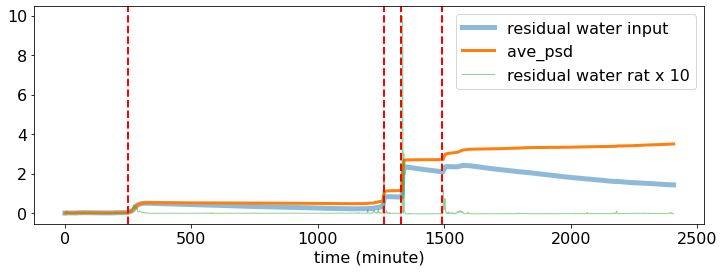

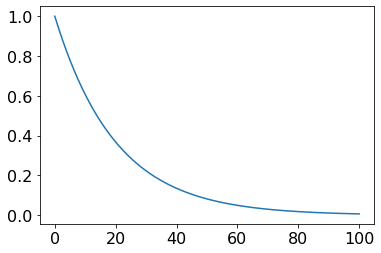

In [18]:
### Incorporate drainage
decay = np.exp(-np.arange(6000)*5/6000)
res_diff = np.gradient(np.convolve(decay, ave_psd, mode='full')[:2408])

plt.figure(figsize=(12, 4))
plt.plot(np.cumsum(res_diff), label='residual water input',lw=5, alpha=0.5)
plt.plot(np.cumsum(ave_psd), label='ave_psd', lw=3)
plt.plot(res_diff*20, label='residual water rat x 10',lw=1, alpha=0.5)
plt.legend()
plt.xlabel('time (minute)')
plt.axvline(x=250,  color='r', linestyle='--', lw=2)
plt.axvline(x=1260,  color='r', linestyle='--', lw=2)
plt.axvline(x=1330,  color='r', linestyle='--', lw=2)
plt.axvline(x=1490,  color='r', linestyle='--', lw=2)

plt.figure()
plt.plot(np.arange(6000)/60, decay)

# Evapotranspiration

## Solar radiation

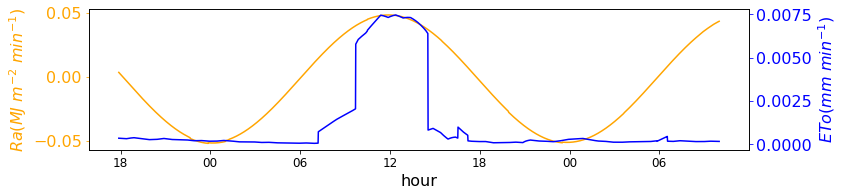

In [19]:
### get the extraterrestrial radiation
lat = 52.78
lon = -2.43
day = 76   ## 17th March
lz = 0  
time = 12.0
duration = 1.0/60  ## 1 minute
rad_a_shortterm(lat, lon, day, lz, time, duration)

rad_every_minute = np.zeros(acqu_time.shape[0])
for imin in range(0, acqu_time.shape[0]):
    day = acqu_time[imin].timetuple().tm_yday
    time = acqu_time[imin].hour + acqu_time[imin].minute/60
    rad_every_minute[imin] = rad_a_shortterm(lat, lon, day, lz, time, 1.0/60)

### get the ETo
rad = np.zeros(2408)
rad[800:950] = 0.25
rad[950:1240] = 0.75
rad[1360:1400] = 0.25
rad[2158:2200] = 0.25
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity)
    
fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.plot(np.arange(acqu_time.shape[0]), rad_every_minute, label='1-minute radiation', color='orange')
ax1.set_xlabel("hour", fontsize=16)
ax1.set_ylabel("$Ra (MJ~m^{-2}~min^{-1})$", fontsize=16, color='orange')
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax, fontsize=12)
ax1.tick_params(axis='y', colors='orange')

ax2 = ax1.twinx()
ax2.plot(np.arange(acqu_time.shape[0]), eto_every_minute, label='1-minute ETo', color='blue')
ax2.set_ylabel("$ETo (mm~min^{-1}$)", fontsize=16, color='blue')
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=12)
ax2.tick_params(axis='y', colors='blue')

fig.tight_layout()
plt.show()

# Model: Precipitation - Evaporation

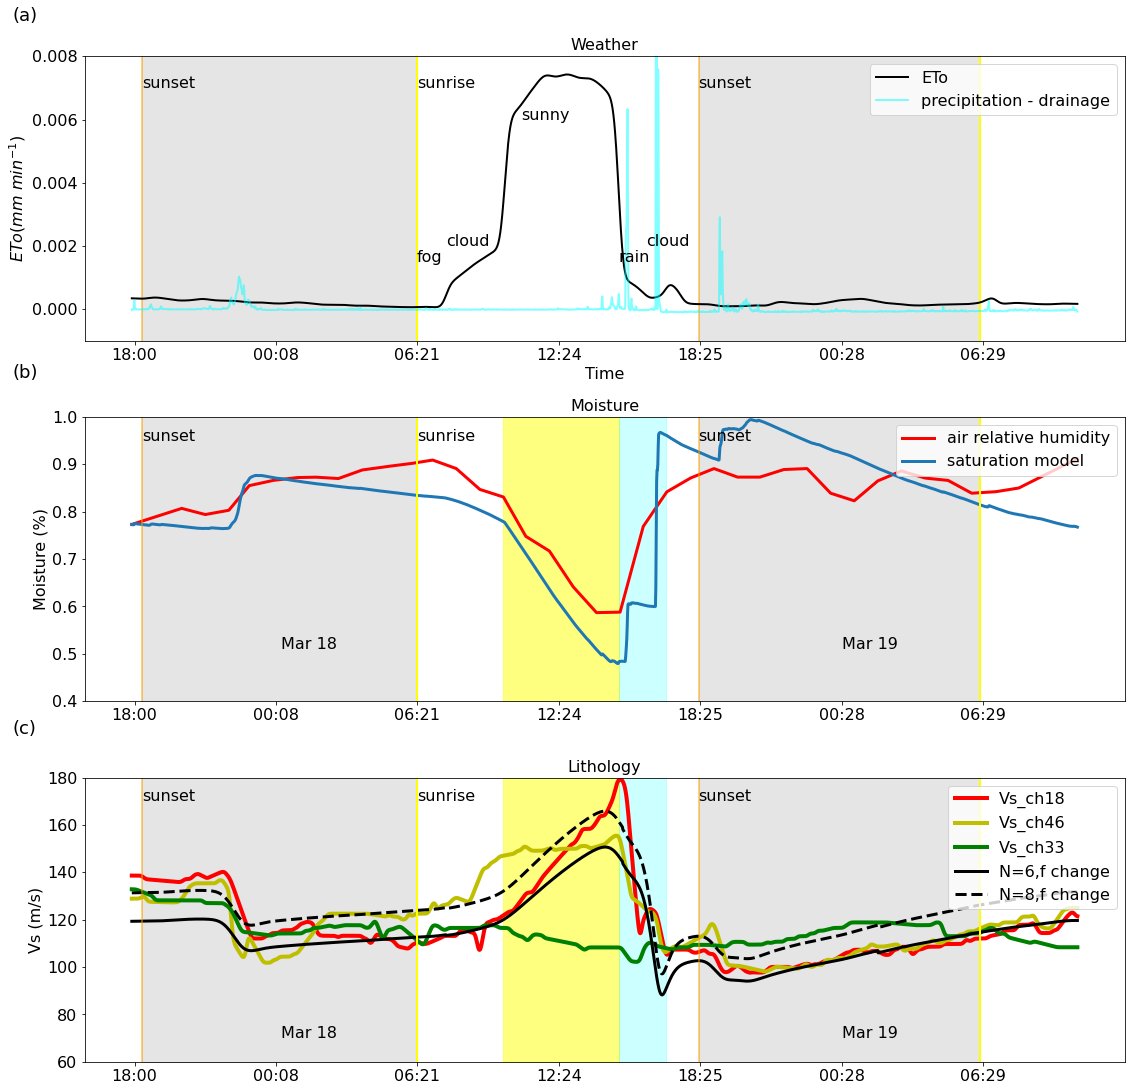

In [20]:
## Model the water balance
A_e = 0.35
# A_d = 0.1
A_d = 0
A_p = 0.12
rad = np.zeros(2408)
rad[800:950] = 0.25
rad[950:1240] = 0.75
rad[1360:1400] = 0.25
rad[2158:2200] = 0.25
rad = rad * rad_every_minute
# eto_every_minute=eto_shortterm(rad, air_temp_interpolated, wind_speed_interpolated*0.75, humidity_interpolated)
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 

decay = np.exp(-np.arange(8000)*5/8000)
res_psd = np.gradient(np.convolve(decay, ave_psd, mode='full')[:2408])
s_history = hydro0(res_psd*2, 0.5, interp_humidity[0]/100-0.05, interp_temp10, 9, eto_every_minute, 0.7, A_p,A_e,A_d).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=25, mode='reflect')

## Model the lithology
## Input parameters
s_wr = 0.3  ## residual saturation
s=interp_humidity/100
# scale_factor = moisture/100 * 2.5 - 0.6
scale_factor = (s_history_smooth+1)/2 * 3 - 0.6
new_f = 0.9-scale_factor/2
   
tau1 = 5e6 * np.exp(np.power(s_history_smooth[0:800],3))  ## wetting
tau2 = 1e7 * (1-s_history_smooth[800:1250])  ## drying
tau3 = 5e6 * np.exp(np.power(s_history_smooth[1250:1900],3))  ## wetting
tau4 = 1e7 * (1-s_history_smooth[1900:])  ## drying
tau = np.concatenate((tau1, tau2, tau3, tau4))

s_rate = np.diff(s_history_smooth) / 60 ## Saturation rate, per second
p_diff = 0-np.concatenate((s_rate, [0])) * tau

bulk_density, porosity = 1400, 0.47
vp_sand, vs_sand,   _, _, _ = litho(bulk_density, porosity, 6, new_f, s_history_smooth, s_wr, tau).get_vp_vs()
vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f, s_history_smooth, s_wr, tau).get_vp_vs()


### Plot the water balance
fig, (ax3, ax1, ax2) = plt.subplots(3, 1, figsize=(16, 15), tight_layout=True)

# Water balance plot
ax1.fill_between(np.arange(2408), 0, 1, where=eto_every_minute > 0.002, color='yellow', alpha=0.5)
ax1.fill_between([1240,1360], [0,0], [1,1], color='cyan', alpha=0.2)
ax1.fill_between([27,726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.plot(np.arange(2408), s-0.05, label='air relative humidity', color='r', lw=3)
ax1.plot(np.arange(2408), s_history, label='saturation model', lw=3)
# ax1.plot(np.arange(2408), s_history_smooth, label='smoothed model', linestyle='--', lw=3)
ax1.set_ylim(0.4, 1)
ax1.set_ylabel("Moisture (%)", fontsize=16)
ax1.set_xticks(xax)
ax1.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax1.set_title("Moisture", fontsize=16)
ax1.legend(loc='upper right')
ax1.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.text(27, 0.95, 'sunset', color='k')
ax1.text(726, 0.95, 'sunrise', color='k')
ax1.text(1443, 0.95, 'sunset', color='k')
# ax1.text(2158, 0.95, 'sunrise', color='k')
ax1.text(Ind6hrs[1] + 20, 0.51, 'Mar 18', color='k')
ax1.text(Ind6hrs[5] + 30, 0.51, 'Mar 19', color='k')

# Lithology plot
ax2.fill_between(np.arange(2408), 60, 180, where=eto_every_minute > 0.002, color='yellow', alpha=0.5)
ax2.fill_between([1240,1360], [60,60], [180,180], color='cyan', alpha=0.2)
ax2.fill_between([27,726], [60,60], [180,180], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [60,60], [180,180], color='gray', alpha=0.2)
# ax2.plot(np.arange(2408), dvv*135, label='org_Vs', lw=2, color='b')
ax2.plot(np.arange(2408), (dvv_all[18]+1)*108, label='Vs_ch18', lw=4, color='r')
ax2.plot(np.arange(2408), (dvv_all[46]+1)*108, label='Vs_ch46', lw=4, color='y')
ax2.plot(np.arange(2408), (dvv_all[33]+1)*108, label='Vs_ch33', lw=4, color='g')
ax2.plot(np.arange(2408), vs_sand, label='N=6,f change', color='k', lw=3)
ax2.plot(np.arange(2408), vs_clay, label='N=8,f change', color='k', lw=3, ls='--')
ax2.set_ylabel("Vs (m/s)", fontsize=16)
ax2.set_title("Lithology", fontsize=16)
ax2.set_xticks(xax)
ax2.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax2.legend(loc='upper right')
ax2.set_ylim(60, 180)
ax2.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.text(27, 170, 'sunset', color='k')
ax2.text(726, 170, 'sunrise', color='k')
ax2.text(1443, 170, 'sunset', color='k')
# ax2.text(2158, 220, 'sunrise', color='k')
ax2.text(Ind6hrs[1] + 20, 70, 'Mar 18', color='k')
ax2.text(Ind6hrs[5] + 30, 70, 'Mar 19', color='k')

# Weather data plot
ax3.fill_between([27,726], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.fill_between([1443,2158], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.set_ylim(-0.001, 0.008)
ax3.text(726, 0.0015, 'fog', color='k')
ax3.text(800, 0.002, 'cloud', color='k')
ax3.text(990, 0.006, 'sunny', color='k')
ax3.text(1240, 0.0015, 'rain', color='k')
ax3.text(1310, 0.002, 'cloud', color='k')
ax3.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax3.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax3.text(27, 0.007, 'sunset', color='k')
ax3.text(726, 0.007, 'sunrise', color='k')
ax3.text(1443, 0.007, 'sunset', color='k')
# ax3.text(2158, 0.007, 'sunrise', color='k')
eto_every_minute_smooth = gaussian_filter1d(eto_every_minute, sigma=10, mode='reflect')
ax3.plot(np.arange(2408), eto_every_minute_smooth, color='k', lw=2, label='ETo')
# ax3.plot(np.arange(2408), etc_smooth, label='inverted ET rate', color='gray', lw=2, linestyle='--')
# ax3.plot(np.arange(2408), ave_psd/20, color='cyan', lw=2, label='relative preciptation rate')
ax3.plot(np.arange(2408), res_diff/20, label='precipitation - drainage',lw=2, alpha=0.5,  color='cyan')
ax3.set_xticks(xax)
ax3.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax3.set_xlabel("Time", fontsize=16)
ax3.set_ylabel("$ETo (mm~min^{-1}$)", fontsize=16)
ax3.set_title("Weather", fontsize=16)
ax3.legend(loc='upper right')

# twinx = ax3.twinx()
# # twinx.plot(np.arange(2408), interp_temp10, color='gray', lw=2, label='temperature')
# twinx.set_ylabel("Soil Temperature", fontsize=16, color='gray')
# twinx.tick_params(axis='y', colors='gray')

fig.text(0.02, 1.0, '(a)', fontsize=18)
fig.text(0.02, 0.67, '(b)', fontsize=18)
fig.text(0.02, 0.34, '(c)', fontsize=18)

plt.tight_layout()
plt.show()

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


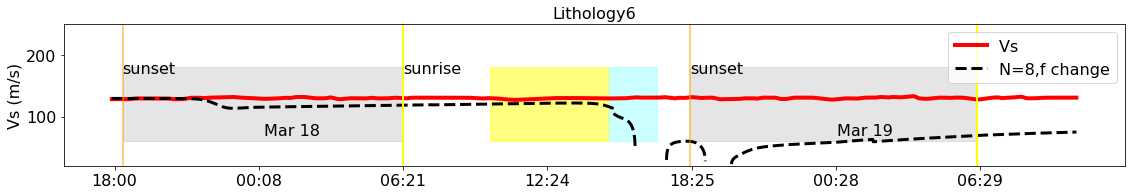

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


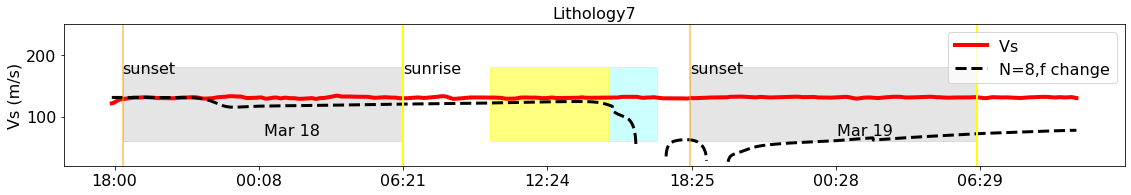

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)


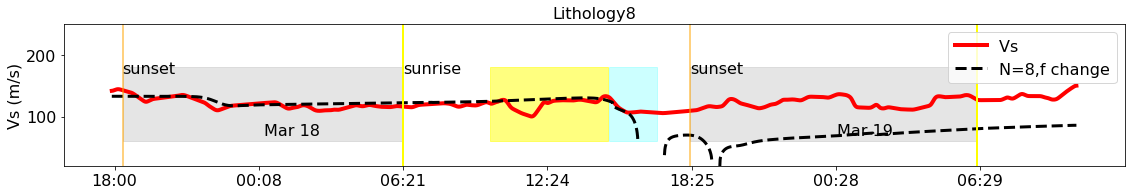

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)


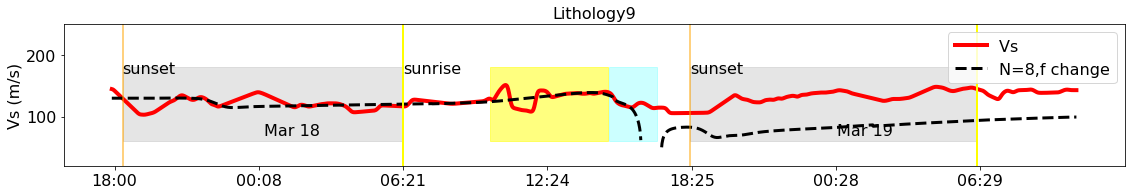

/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


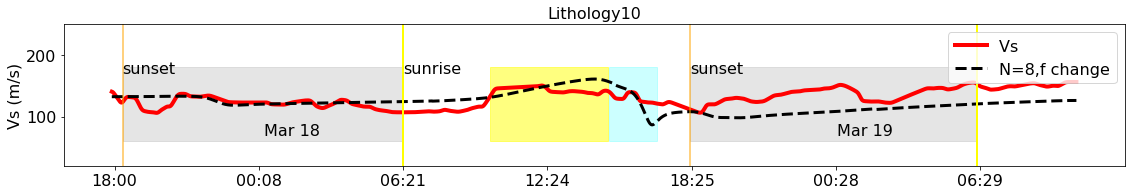

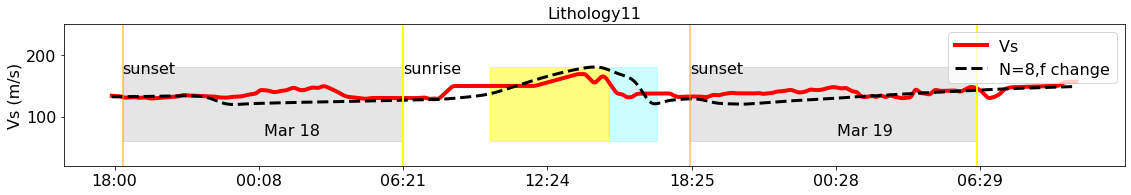

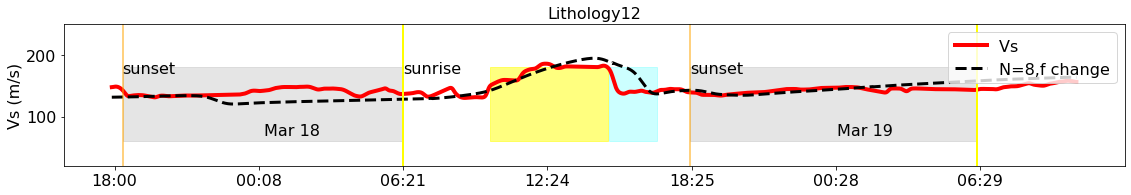

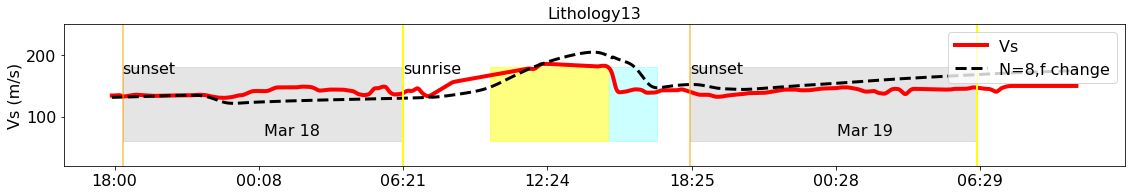

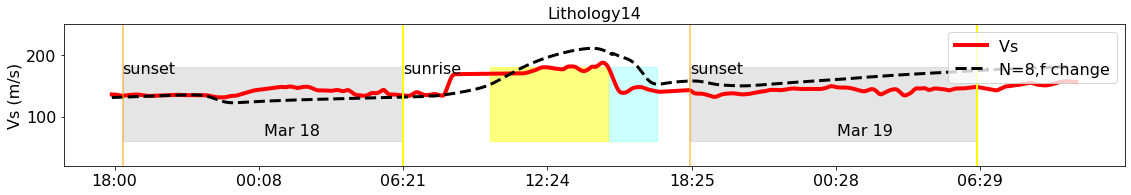

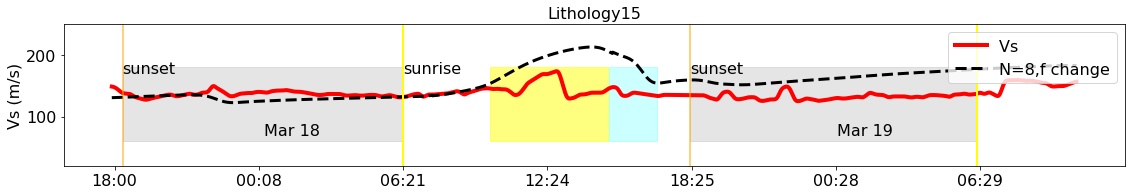

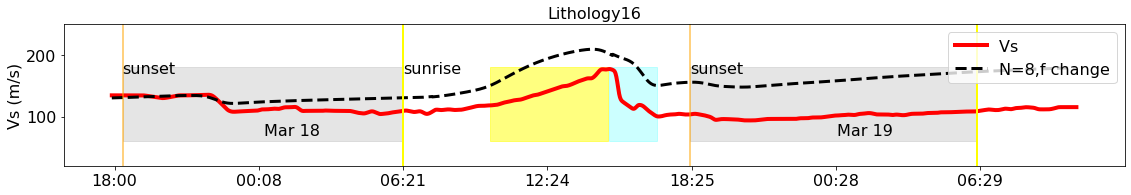

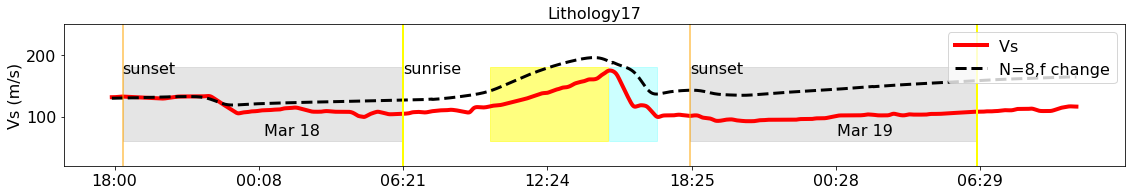

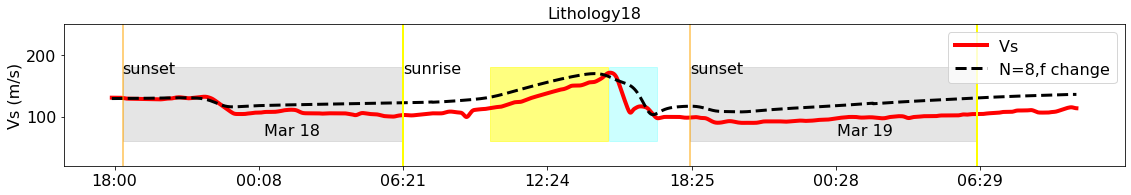

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


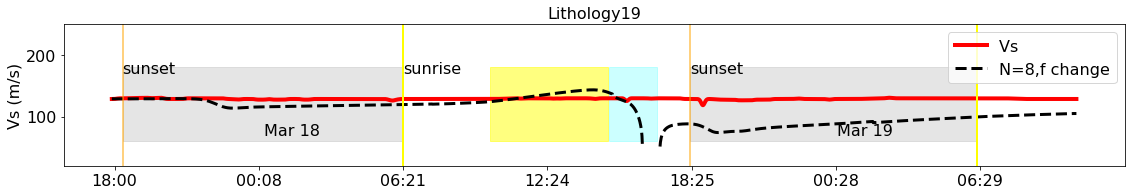

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)


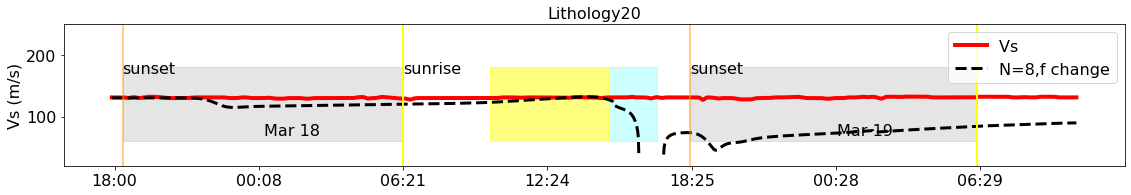

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)


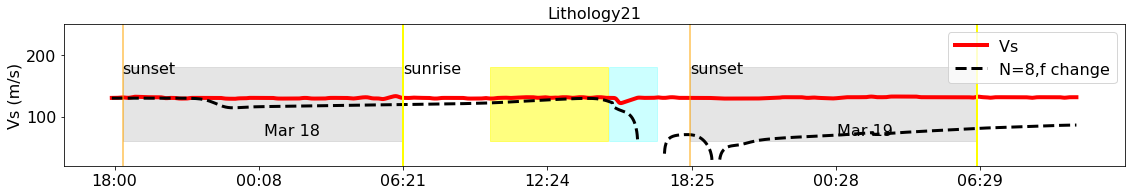

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)


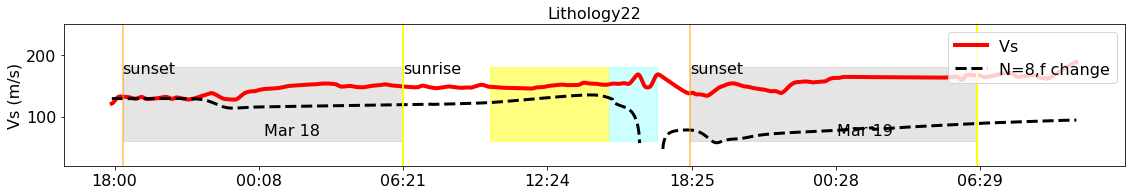

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


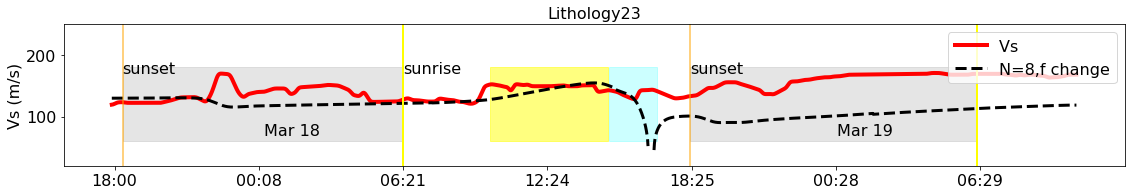

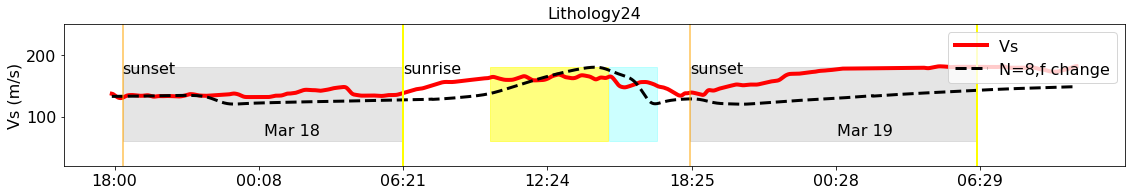

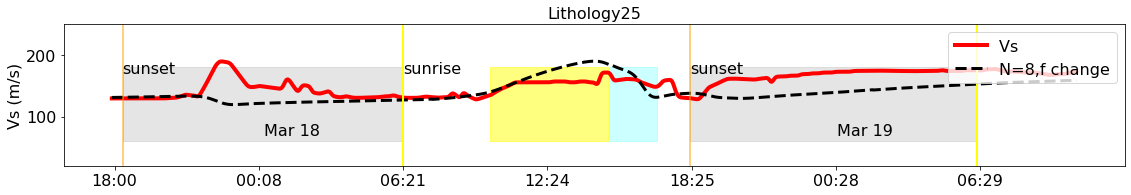

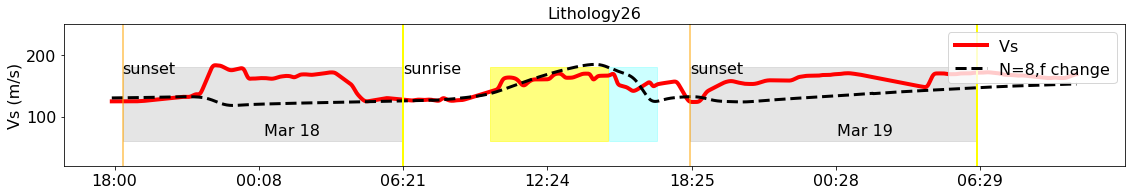

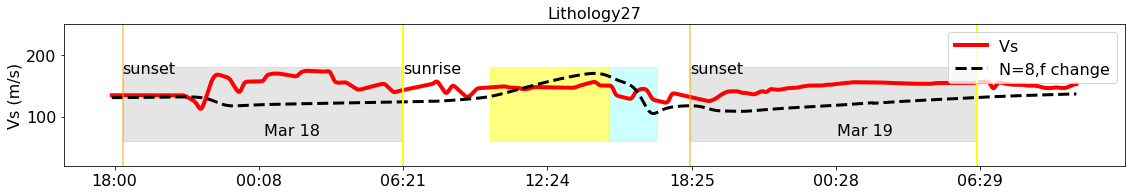

/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


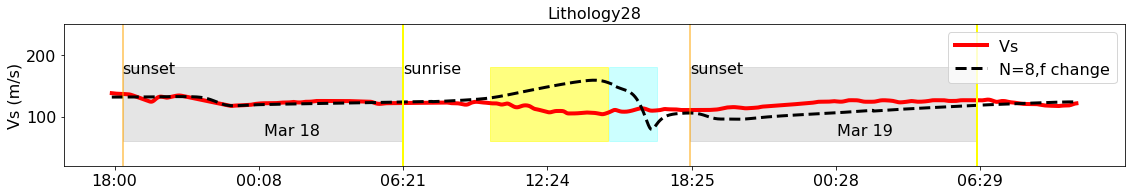

/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


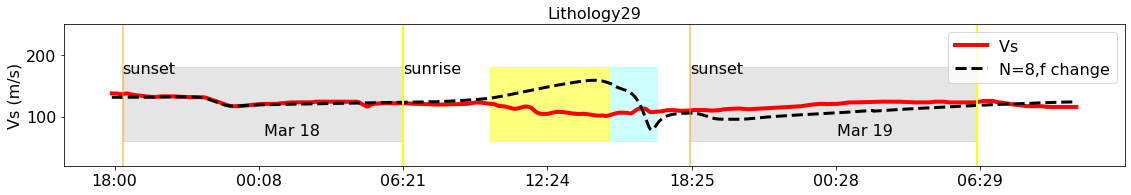

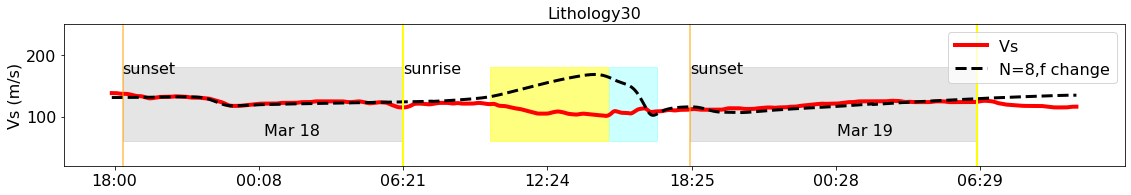

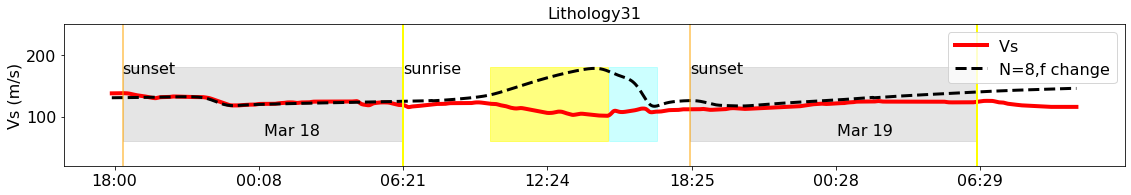

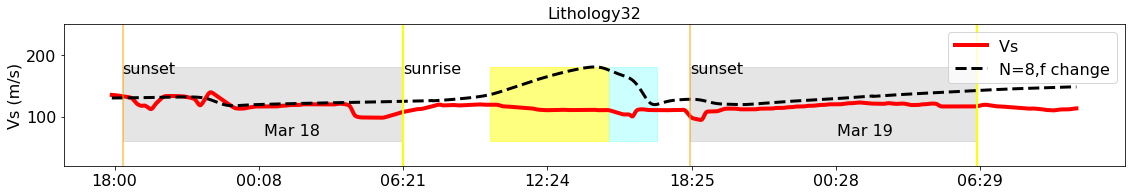

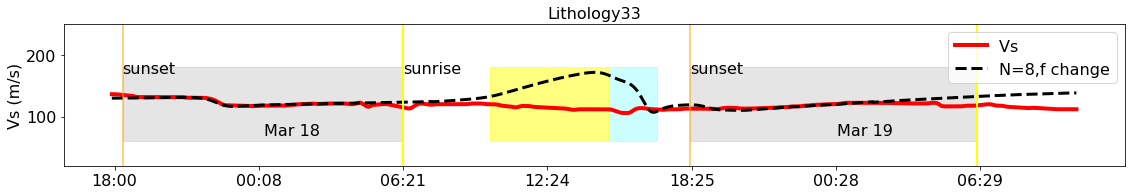

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


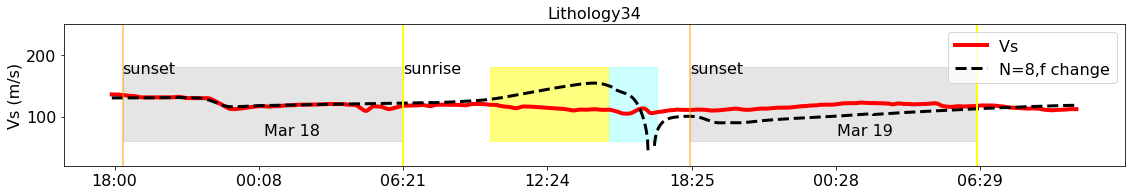

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)


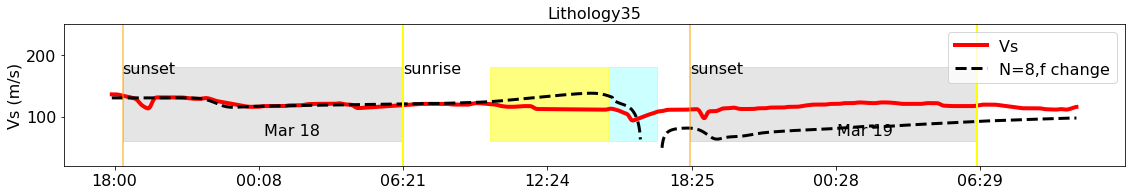

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)


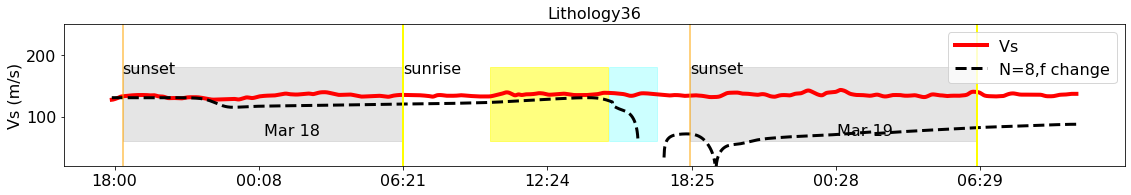

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)


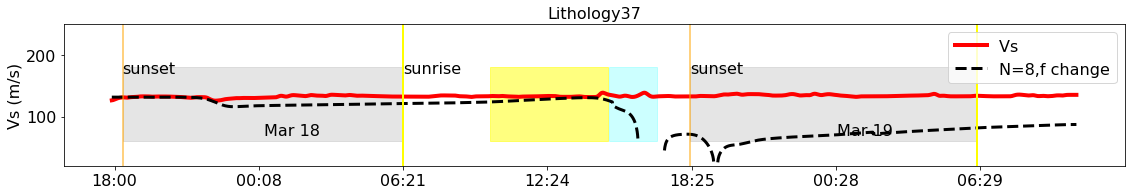

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)


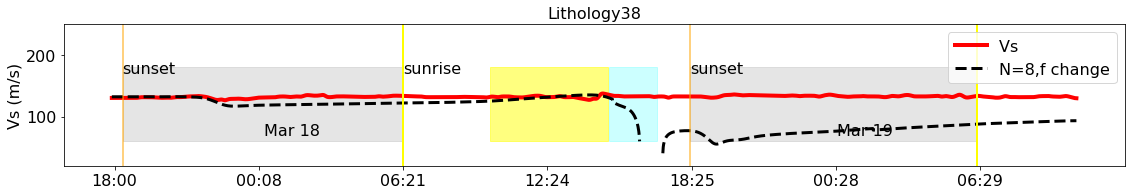

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


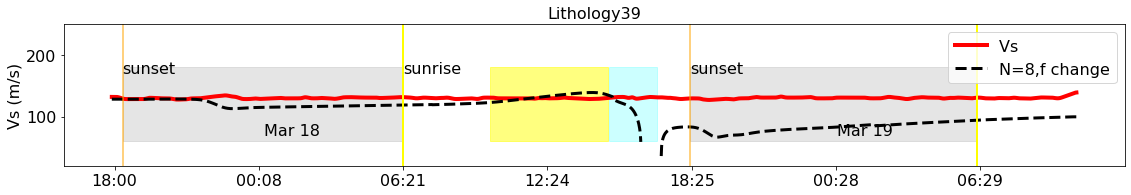

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


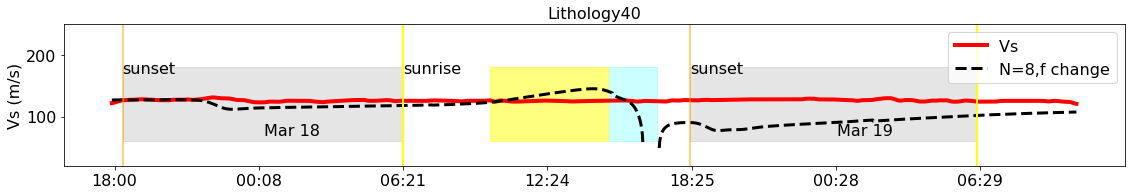

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


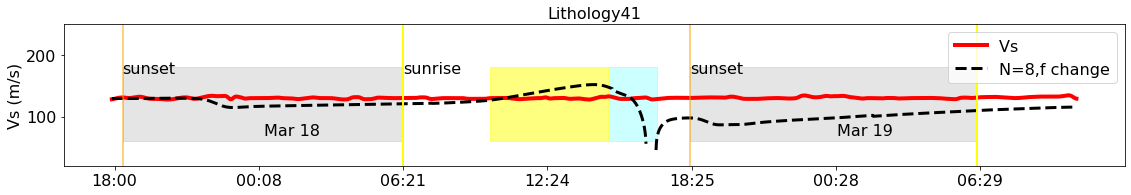

/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


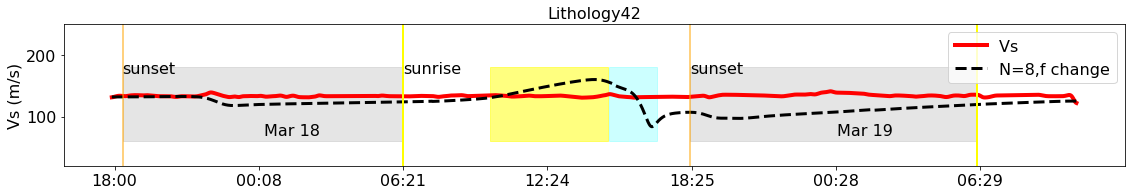

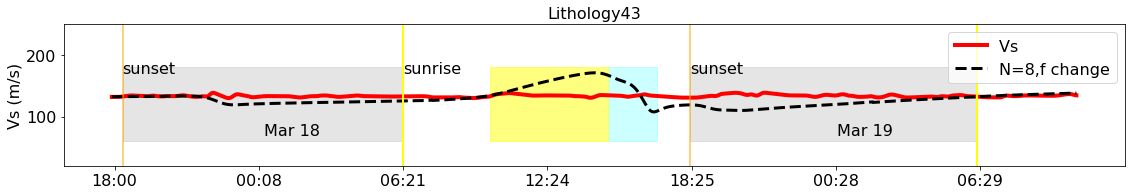

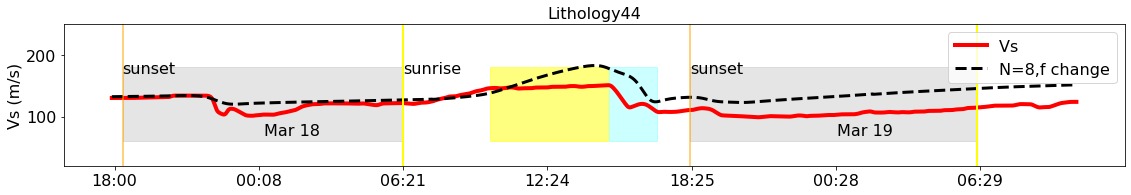

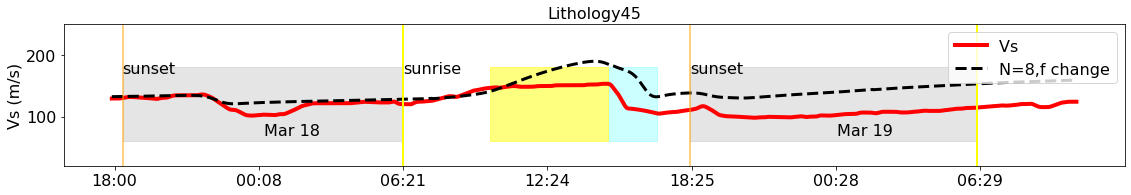

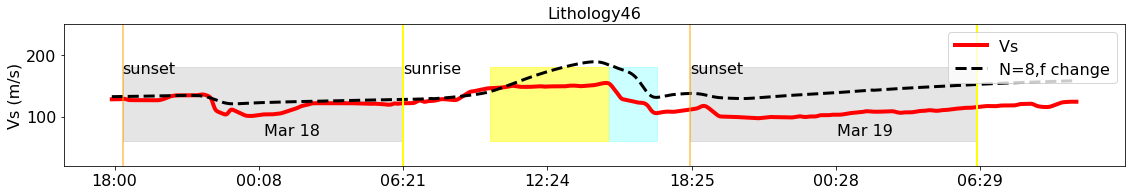

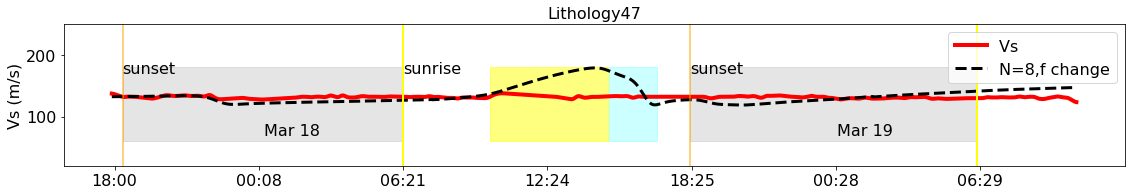

/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


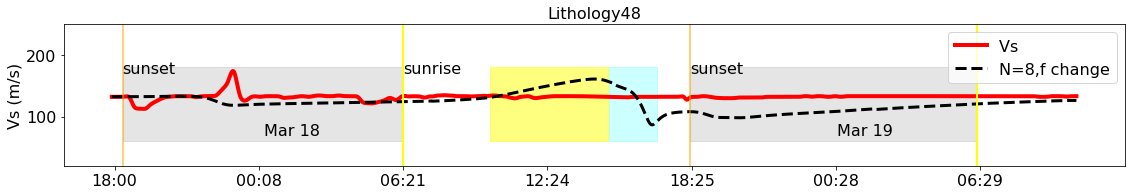

/home/qibins/farmDAS/./src/soil_models.py:149: RuntimeWarning: invalid value encountered in power
  self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
/home/qibins/farmDAS/./src/soil_models.py:156: RuntimeWarning: invalid value encountered in sqrt
  self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)


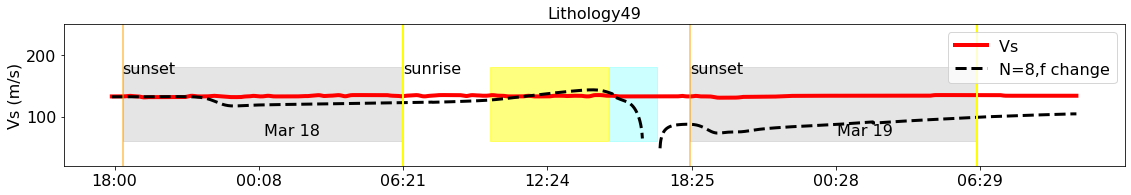

In [50]:
vs_ref = []

for iloc in np.arange(6,50):
    A_e = 0.9
    A_d = 0
    A_p = 0.12

    ## Model the water balance
    s_history = hydro0(res_psd*2, 0.5, interp_humidity[0]/100-0.05, interp_temp10, 9, eto_every_minute, damage_index[iloc-6], A_p,A_e,A_d).get_s_history()
    s_history_smooth = gaussian_filter1d(s_history, sigma=25, mode='reflect')

    ## Model the lithology
    s_wr = 0.3  ## residual saturation
    s=interp_humidity/100
    scale_factor = (s_history_smooth+1)/2 * 3 - 0.6
    new_f = 0.9-scale_factor/2
    
    tau1 = 5e6 * np.exp(np.power(s_history_smooth[0:800],3))  ## wetting
    tau2 = 1e7 * (1-s_history_smooth[800:1250])  ## drying
    tau3 = 5e6 * np.exp(np.power(s_history_smooth[1250:1900],3))  ## wetting
    tau4 = 1e7 * (1-s_history_smooth[1900:])  ## drying
    tau = np.concatenate((tau1, tau2, tau3, tau4))

    s_rate = np.diff(s_history_smooth) / 60 ## Saturation rate, per second
    p_diff = 0-np.concatenate((s_rate, [0])) * tau

    bulk_density, porosity = interp_bulk_density_30cm[iloc]*1000, interp_porosity_30cm[iloc]/100
    vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f, s_history_smooth, s_wr, tau).get_vp_vs()

    vs_clay_ref = np.mean(vs_clay[150:210])
    vs_ref.append(vs_clay_ref)
    vs_correction = vs_clay_ref - np.mean((dvv_all[iloc, 150:210]+1)*108)

    ### Plot the water balance
    fig, ax2 = plt.subplots(1, 1, figsize=(16, 3), tight_layout=True)

    # Lithology plot
    ax2.fill_between(np.arange(2408), 60, 180, where=eto_every_minute > 0.002, color='yellow', alpha=0.5)
    ax2.fill_between([1240,1360], [60,60], [180,180], color='cyan', alpha=0.2)
    ax2.fill_between([27,726], [60,60], [180,180], color='gray', alpha=0.2)
    ax2.fill_between([1443,2158], [60,60], [180,180], color='gray', alpha=0.2)
    # ax2.plot(np.arange(2408), dvv*135, label='org_Vs', lw=2, color='b')
    ax2.plot(np.arange(2408), (dvv_all[iloc]+1)*108 + vs_correction, label='Vs ', lw=4, color='r')
    ax2.plot(np.arange(2408), vs_clay, label='N=8,f change', color='k', lw=3, ls='--')
    ax2.set_ylabel("Vs (m/s)", fontsize=16)
    ax2.set_title("Lithology"+str(iloc), fontsize=16)
    ax2.set_xticks(xax)
    ax2.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
    ax2.legend(loc='upper right')
    ax2.set_ylim(20, 250)
    ax2.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
    ax2.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
    ax2.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
    ax2.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
    ax2.text(27, 170, 'sunset', color='k')
    ax2.text(726, 170, 'sunrise', color='k')
    ax2.text(1443, 170, 'sunset', color='k')
    # ax2.text(2158, 220, 'sunrise', color='k')
    ax2.text(Ind6hrs[1] + 20, 70, 'Mar 18', color='k')
    ax2.text(Ind6hrs[5] + 30, 70, 'Mar 19', color='k')


    plt.tight_layout()
    plt.show()